# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder)

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation.


### Pre-Setup

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os

# List of cache directories to check
caches_dir = [r"E:\SnapfoliaV2\.cache", "F:/.cache/", "D:/cache/"]

# Function to set cache directory
def set_cache_dir(caches_dir):
    for cache in caches_dir:
        if not os.path.exists(cache):
            try:
                os.makedirs(cache)  # Create directory if it doesn't exist
                print(f"Created cache directory: {cache}")
            except OSError as e:
                print(f"Error creating cache directory {cache}: {e}")
                continue
        
        # Set environment variable HF_HOME to the first existing cache directory
        os.environ['HF_HOME'] = cache
        print(f"Cache path set to: {cache}")
        break  # Exit loop once cache directory is set

    else:
        print("None of the specified cache directories exist.")

# Call the function to set cache directory
set_cache_dir(caches_dir)

Cache path set to: E:\SnapfoliaV2\.cache


Before we start, let's install the `datasets`, `transformers` and `accelerate` libraries.

In [ ]:
!pip install transformers==4.39.3
!pip install -q datasets accelerate
!pip install -q evaluate
!pip install pandas
!pip install matplotlib
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install wandb

In [ ]:
!conda install anaconda::ipywidgets

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

### Huggingface Login & wandb

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import wandb
wandb.login()


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Loading the dataset

In [20]:
# pre-trained model
model_checkpoint = r"huggingface\models\google\vit-base-patch16-224"

In [21]:
import os

path = r"C:\Users\faith\Documents\Snapfolia - CS\Samples\splitted_dataClean" # data path
if not os.path.exists(path):
    print(f"Path does not  exist {path}")
else:
    print(f'Data path set on {path}')

Data path set on C:\Users\faith\Documents\Snapfolia - CS\Samples\splitted_dataClean


In [22]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature
dataset = load_dataset("imagefolder", data_dir=path)

Resolving data files:   0%|          | 0/3612 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1026 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3510
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1004
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 496
    })
})

In [24]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Apitong', 'Balete', 'Bayabas', 'Guyabano', 'Kamagong', 'Langka', 'Mahogany', 'Mangga', 'Palo Maria'], id=None)}

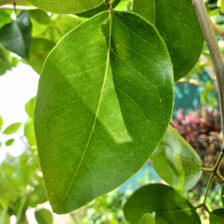

In [25]:
example = dataset['train'][310]['image']
example.resize(size=(224, 224)).save("example_tree_resized.jpg", quality=95)
example.save("example_tree.jpg", quality=95)
example.resize(size=(224, 224))

Let's print the corresponding label:

In [26]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

label2id

{'Apitong': 0,
 'Balete': 1,
 'Bayabas': 2,
 'Guyabano': 3,
 'Kamagong': 4,
 'Langka': 5,
 'Mahogany': 6,
 'Mangga': 7,
 'Palo Maria': 8}

### Preprocessing the data

In [27]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [40]:
import torch
import random
from torchvision.transforms.v2 import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    RandAugment,
    RandomRotation,
    ToImage,
    ToDtype,
    Lambda,
    Grayscale,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            ToImage(),
            RandomHorizontalFlip(p=0.5),
            RandomResizedCrop(crop_size, scale=(0.5, 1.0)),
            # RandAugment(num_ops=2),
            Grayscale(),
            RandomRotation(10),
            ToDtype(torch.float32, scale=True),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            ToImage(),
            Resize(size),
            Grayscale(),
            CenterCrop(crop_size),
            ToDtype(torch.float32, scale=True),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [41]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2, shuffle=True)
test_valid = splits['test'].train_test_split(test_size=0.1)

train_ds = splits['train']
val_ds = splits['test']
test_ds = test_valid['test']


In [42]:
print(f"Main splits:\n {splits}\n\n")
print(f"Test+Valid:\n {test_valid}")

Main splits:
 DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2808
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 702
    })
})


Test+Valid:
 DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 631
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 71
    })
})


In [43]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

### Logging Visualization WANDB

In [45]:
# # set the wandb project where this run will be logged
# os.environ["WANDB_PROJECT"]="fatih-tree-bark"

# # # save your trained model checkpoint to wandb
# os.environ["WANDB_LOG_MODEL"]="true"

# # # turn off watch to log faster
# os.environ["WANDB_WATCH"]="false"

# # turn off wandb
os.environ["WANDB_DISABLED"] = "true"

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

In [51]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at huggingface\models\google\vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

#### Modifying Class Weights


In [47]:
def print_cweights() -> None:
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"Layer: {name} | Weights: {param.data}")
print_cweights()

Layer: vit.embeddings.patch_embeddings.projection.weight | Weights: tensor([[[[ 7.8485e-03,  4.2280e-02,  5.0357e-02,  ...,  8.3660e-02,
            1.0607e-01,  1.2280e-01],
          [ 5.8864e-03,  9.8257e-03,  1.1276e-02,  ...,  8.3052e-02,
            3.5916e-02,  8.6425e-02],
          [ 1.8189e-02,  1.2374e-02, -7.2332e-03,  ...,  7.9424e-02,
            3.3450e-02,  3.6081e-02],
          ...,
          [-1.7554e-02, -6.0254e-03, -6.0988e-02,  ..., -6.0744e-02,
           -7.1743e-02,  1.7526e-02],
          [ 3.8352e-02, -4.4822e-02, -2.1625e-02,  ...,  1.1101e-02,
           -4.3369e-02,  8.0290e-02],
          [ 6.6413e-02,  8.0208e-02,  3.8246e-02,  ...,  9.6041e-02,
            1.1482e-01,  1.5289e-01]],

         [[-6.7483e-02, -4.1827e-02, -4.3038e-02,  ..., -6.9159e-02,
           -3.0319e-02, -2.2574e-02],
          [-1.1597e-02, -1.0468e-02, -1.1591e-02,  ..., -3.8808e-02,
           -5.1213e-02, -1.5044e-03],
          [ 5.1395e-02,  3.8724e-02,  1.5236e-02,  ..., -3.

In [48]:
import numpy as np

# Assuming 'label' is the key for the target labels in your dataset
labels = dataset['train']['label']  # Replace 'train' with 'validation' or 'test' as needed
class_labels = np.unique(labels)
total_samples = len(labels)
samples_per_class = [np.sum(labels == label) for label in class_labels]

print("Samples per class:", samples_per_class)

initial_class_weights = [total_samples / samples_per_class[i] for i in range(len(class_labels))]

class_weights = [np.log1p(weight) for weight in initial_class_weights]

print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)


Samples per class: [380, 411, 396, 364, 389, 403, 426, 355, 386]
Initial class weights: [9.236842105263158, 8.540145985401459, 8.863636363636363, 9.642857142857142, 9.023136246786633, 8.709677419354838, 8.23943661971831, 9.887323943661972, 9.093264248704664]
Log-scaled class weights: [2.3259931838920607, 2.255508787796097, 2.2888549001821437, 2.3648889763302003, 2.304896045364151, 2.2731230602637296, 2.2234809119027736, 2.3875991715461065, 2.311868295297595]


In [49]:
# scaling_factor = 0.1

# for name, param in model.named_parameters():
#     if "weight" in name:
#         with torch.no_grad():
#             param.data *= scaling_factor

In [50]:
print_cweights()

Layer: vit.embeddings.patch_embeddings.projection.weight | Weights: tensor([[[[ 7.8485e-03,  4.2280e-02,  5.0357e-02,  ...,  8.3660e-02,
            1.0607e-01,  1.2280e-01],
          [ 5.8864e-03,  9.8257e-03,  1.1276e-02,  ...,  8.3052e-02,
            3.5916e-02,  8.6425e-02],
          [ 1.8189e-02,  1.2374e-02, -7.2332e-03,  ...,  7.9424e-02,
            3.3450e-02,  3.6081e-02],
          ...,
          [-1.7554e-02, -6.0254e-03, -6.0988e-02,  ..., -6.0744e-02,
           -7.1743e-02,  1.7526e-02],
          [ 3.8352e-02, -4.4822e-02, -2.1625e-02,  ...,  1.1101e-02,
           -4.3369e-02,  8.0290e-02],
          [ 6.6413e-02,  8.0208e-02,  3.8246e-02,  ...,  9.6041e-02,
            1.1482e-01,  1.5289e-01]],

         [[-6.7483e-02, -4.1827e-02, -4.3038e-02,  ..., -6.9159e-02,
           -3.0319e-02, -2.2574e-02],
          [-1.1597e-02, -1.0468e-02, -1.1591e-02,  ..., -3.8808e-02,
           -5.1213e-02, -1.5044e-03],
          [ 5.1395e-02,  3.8724e-02,  1.5236e-02,  ..., -3.

The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

#### Hyperparameters

In [52]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 32
class_len = len(dataset['train'].features['label'].names)

args = TrainingArguments(
    f"{model_name}-finetuned-leaf-{class_len}",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    # gradient_accumulation_steps=8,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=64,
    warmup_ratio=0.01,
    fp16=True,
    weight_decay=1e-5,
    logging_steps=50,
    logging_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none",
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [53]:
import evaluate
import numpy as np
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.

def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("f1")
    metric4 = evaluate.load("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision = metric1.compute(predictions=predictions, references=labels, average="macro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="macro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="macro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [54]:
from transformers import TrainerCallback
from copy import deepcopy

class CustomCallback(TrainerCallback):
    # This is for getting the accuracy logs
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [55]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [63]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
trainer.add_callback(CustomCallback(trainer)) 

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

#### Train

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\faith\anaconda3\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.801200,1.194128,0.799992,0.784778,0.785496,0.794872
2,0.620000,nan,0.887841,0.881723,0.882673,0.881766
3,0.230300,0.262310,0.937804,0.933584,0.934109,0.934473
4,0.130000,0.199173,0.950376,0.947842,0.947427,0.947293


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate(eval_dataset=test_ds)
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
#trainer.push_to_hub()

In [ ]:
# wandb.finish()

### Visualization

In [ ]:
import pandas as pd
history = trainer.state.log_history
history

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extract relevant data
train_losses = []
eval_losses = []

eval_accuracy = []
train_accuracy = []

for item in history[:-2]: # exclude the log history of evaluation
    if 'loss' in item:
        train_losses.append(item['loss'])
    if 'eval_loss' in item:
        eval_losses.append(item['eval_loss'])
    if 'eval_accuracy' in item:
        eval_accuracy.append(item['eval_accuracy'])
    if 'train_accuracy' in item:
        train_accuracy.append(item['train_accuracy'])
        
        
# Plot
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)

# Plot training and  evaluation losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot evaluation and training accuracy 
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Evaluation Accuracies')
plt.legend()

plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots
plt.savefig("train_and_eval.jpg", dpi=300)
plt.show()


# Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load an image of tree bark, and see how the model does.

In [ ]:
os.listdir()

In [ ]:
from PIL import Image
import requests

img_path = r"example_tree.jpg"
image = Image.open(img_path)
image.resize(crop_size)

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = f"{model_name}-finetuned-FBark"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", repo_name)

In [ ]:
pipe(image)

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and mage processors:

In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [ ]:
pipe(image)